# Getting started

In [1]:
import numpy as np
import corner
import pandas as pd
import matplotlib.pyplot as plt
import exoplanet as xo
import pymc3 as pm
import lightkurve as lk

In [2]:
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

In this notebook, we're going to inspect and fit the time delays for a well known Kepler $\delta$ Scuti system, KIC 9651065. This tutorial assumes basic working knowledge of PyMC3. [A great introduction to this can be found here](https://docs.exoplanet.codes/en/stable/tutorials/intro-to-pymc3/)

Now, let's first download the light curve.

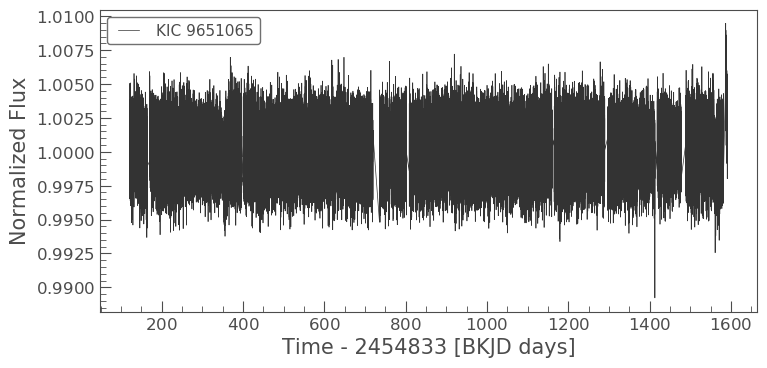

In [3]:
lc = lk.search_lightcurvefile('KIC 9651065', mission='Kepler').download_all().PDCSAP_FLUX.stitch().remove_nans()
lc.plot()

.. Note::
    Lightkurve automatically subtracts the Kepler zero time (2454844 days), so all times are reported in Barycentric Kepler Julian Date (BKJD). _If you want to include additional data, you must work within the same reference time_. 

Here, we pass the time and flux data into `Maelstrom`. If the `freq` argument is not specified, `Maelstrom` will automatically try and detect some good peaks to use. Be warned however, this does not always work and you should always check which frequencies you use! I have set the upper limit on the peak search to 40 d$^{-1}$, since there are some Nyquist aliases. We can tell they are aliases as their time delays will match the Kepler orbital period. Neat!

`first_look` will subdivide the lightcurve using the old method, and make some diagnostic plots. In order, these are the light curve, the amplitude spectrum, the extracted time delays, and the periodogram of the time delays. The frequencies are colored by their amplitude, and the orange line is the weighted average value. We see a nice peak around 272 d in the last panel, which is the orbital period of the system.

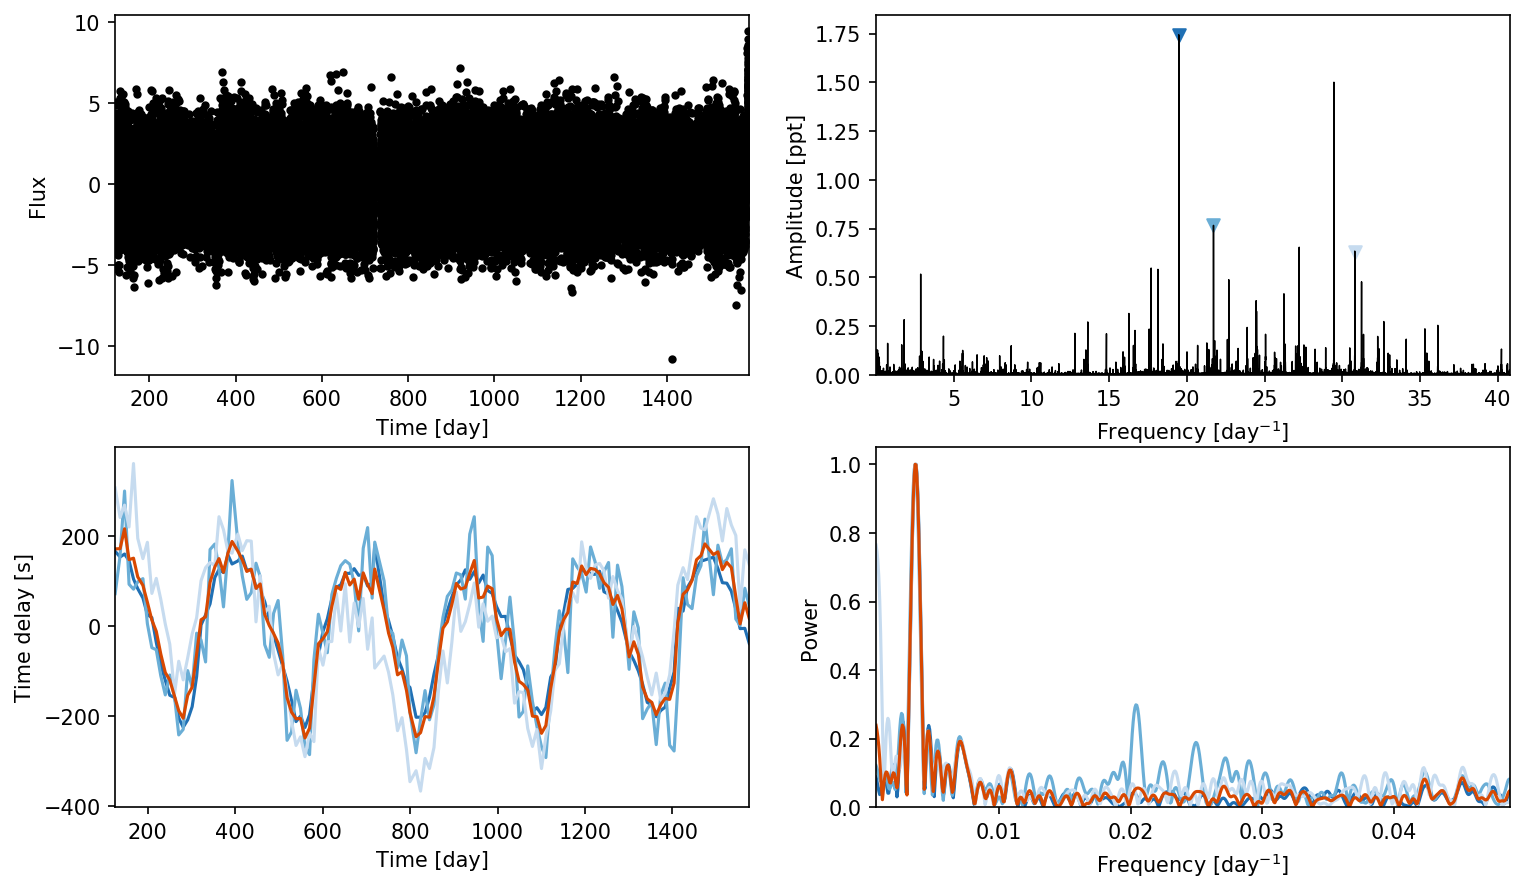

In [6]:
from maelstrom import Maelstrom

ms = Maelstrom(lc.time, lc.flux, max_peaks=3, fmin=5, fmax=40)
ms.first_look();

Note that if you want the frequencies `Maelstrom` has found, simply call `ms.freq`

In [14]:
print(f"Oscillation modes are at {ms.freq}")

Oscillation modes are at [19.47767606 21.71213419 30.80189468]


To read off this period, we can calculate the peak in the power spectrum of the time delays (the bottom left panel above)

In [9]:
period_guess = ms.get_period_estimate()
print(f"The orbital period is around {period_guess:.2f} days")

The orbital period is around 269.96 days


This is pretty good for a few lines of code! In fact, the actual orbital period is closer to 272 d.

Let's now perform an initial optimisation..
We first need to call `setup_orbit_model`, but an orbital period estimate is not required (unless the time delay signal is very weak..!). We can also pass along an initial guess for the eccentricity, but let's leave it at 0 and see what happens.

In [12]:
ms.setup_orbit_model(period=period_guess)
opt = ms.optimize()

In [13]:
opt

{'logperiod': array(5.60521922),
 't0': array(15.39716591),
 'varpi_angle__': array([ 3.64010862, -2.59799919]),
 'eccen_interval__': array(-0.19682975),
 'logs': array(0.21291598),
 'lighttime': array([178.34565426, 191.30015751, 193.97131511]),
 'mean_flux': array(0.00075224),
 'W_hat_cos': array([ 1.7414353 ,  0.46678714, -0.59316665]),
 'W_hat_sin': array([ 0.2940882 ,  0.62832883, -0.28794189]),
 'period': array(271.84151162),
 'varpi': array(2.19066763),
 'eccen': array(0.4509518),
 'tref': array(24.82834397)}

Let's go through some of those parameters for a sec. The ones not mentioned are nuisance parameters which are required for the model.

 - `t0`: Time of periastron passage (d)
 - `lighttime`: The projected semi-major axis calculated for each frequency in the model. Note that most of these agree, indicating that all the frequencies in the `Maelstrom` model belong to the same star.
 - `period`: The orbital period of the system.
 - `varpi`: The angle between the ascending node and periapsis
 - `eccen`: Orbital eccentricity
 - `tref`: Time of reference passage of periapsis

Let's see what the theoretical time delays look like in the optimised model vs the actual extracted values.

In [20]:
td_time, td_td = ms.get_time_delay()
td_average = np.average(td_td, axis=-1, weights=ms.get_weights())

Text(0, 0.5, 'Time delay [s]')

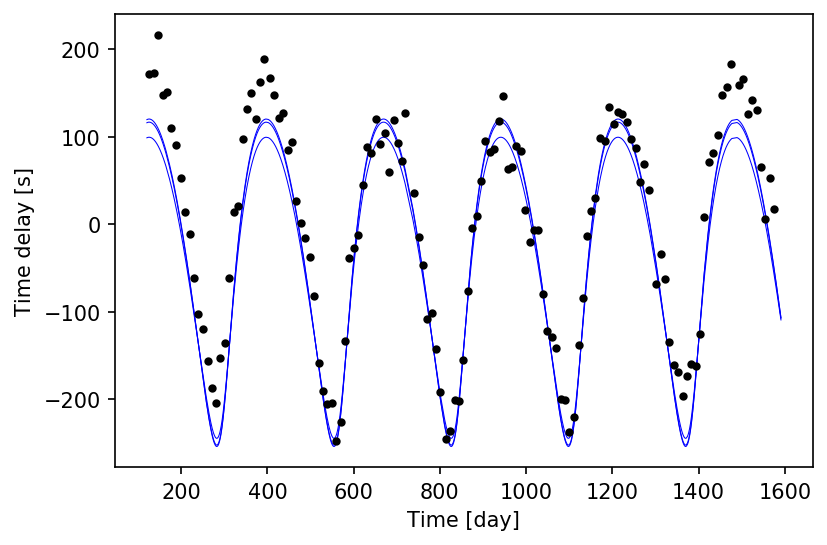

In [21]:
with ms:
    model_td = xo.eval_in_model(ms.tau, opt) * 86400
    plt.plot(ms.time, model_td - np.median(model_td), c='blue', linewidth=0.5)
    plt.plot(td_time, td_average, '.k')
    
plt.xlabel('Time [day]')
plt.ylabel('Time delay [s]')

Cool! Each frequency in the light curve has its own independent `asini` in the Maelstrom model. This is useful for when there are multiple stars pulsating in the same binary system, as they would be (mostly) equal and opposite in sign.

However, Maelstrom isn't actually fitting these parameters. What we're doing is forward modelling the input light curve by fitting the phase variations ($\tau$) in each point;

$y(t) = \sum_{j=1}^{J} \Big[A_j \cos(\omega_j (t - \tau)) + B_j \sin(\omega_j (t-\tau))\Big]$

Although it is not as useful as looking at the time-delays, we can still inspect the actual light curve that is generated from the time delay signal:

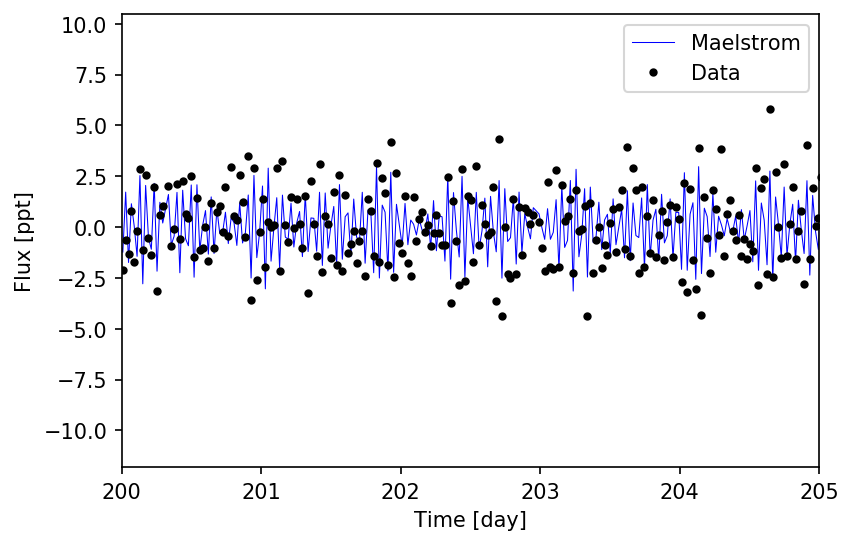

In [22]:
with ms:
    plt.plot(ms.time, xo.eval_in_model(ms.lc_model, opt), c='blue', linewidth=0.5, label='Maelstrom')
    plt.plot(ms.time, ms.flux, '.k', label='Data')
plt.xlim(200,205)
plt.xlabel('Time [day]')
plt.ylabel('Flux [ppt]')
plt.legend()

Maelstrom has decided that all these frequencies belong to one star, as their lighttimes are all positive (or negative). This means the system is PB1. We can get a ready-made model from the get go by asking nicely, and passing in the optimisation results. The PB1 model is for binaries with only one pulsating component. All the frequencies now use the same `asini` parameter, unlike our first model

In [24]:
pb1_model = ms.pin_orbit_model(opt)
pb1_model

As we can see, pb1_model inherits from the PyMC3 Models object. It is, by definition, a custom model which has access to all of the properties of the default Model class. This means we can do cool things like this:

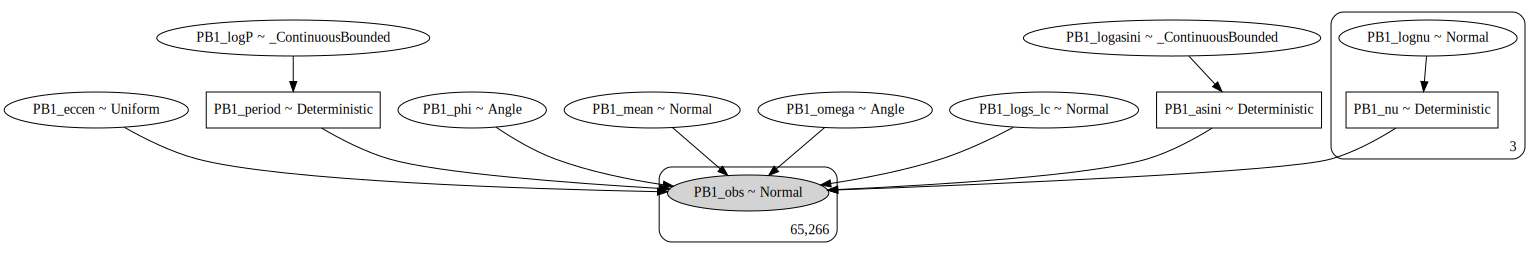

In [25]:
pm.model_to_graphviz(pb1_model)

Finally, if we are happy with the default priors in Maelstrom we can sample the model. There are strong covariances between some of the parameters. This means that sampling will slow down significantly unless we use a custom NUTS step (see https://exoplanet.dfm.io/en/stable/tutorials/pymc3-extras/#dense-mass-matrices)

Sampling is quite slow while the mass matrix is tuned (typically the first 1000 steps). Because of this, I'm only going to make 10 draws of the posterior distribution.

In [27]:
trace = pb1_model.sample(tune=10, draws=10)

optimizing logp for variables: [PB1_mean]
4it [00:00, 22.28it/s, logp=-1.150728e+05]
message: Optimization terminated successfully.
logp: -115072.80884284787 -> -115072.7881902971
optimizing logp for variables: [PB1_logs_lc]
8it [00:00, 27.62it/s, logp=-1.097041e+05]
message: Optimization terminated successfully.
logp: -115072.7881902971 -> -109704.06934437387
optimizing logp for variables: [PB1_omega, PB1_eccen]
45it [00:01, 26.08it/s, logp=-1.066786e+05]
message: Optimization terminated successfully.
logp: -109704.06934437387 -> -106678.6001791905
optimizing logp for variables: [PB1_phi]
20it [00:00, 26.86it/s, logp=-1.066570e+05]
message: Optimization terminated successfully.
logp: -106678.6001791905 -> -106657.04265097293
optimizing logp for variables: [PB1_lognu]
103it [00:03, 32.85it/s, logp=-1.066545e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: -106657.04265097293 -> -106654.54220594438
optimizing logp for variables: [PB1_eccen, PB1_omega, PB

Look at all those errors! That's because we only sampled for 10 steps across 2 chains. For a full sampling run, check out the case studies in the sidebar.

In any case, our trace is a PyMC3 trace object which can be manipulated accordingly:

In [28]:
pm.summary(trace)

/Users/danielhey/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
PB1_logs_lc,0.212922,8.600234e-06,2.719611e-06,0.212913,0.212931,NaN,234.349313
PB1_mean,0.000748,9.571820e-06,3.026826e-06,0.000739,0.000758,NaN,103.871715
PB1_lognu__0,2.969269,3.418779e-08,1.057404e-08,2.969269,2.969269,NaN,4.133664
PB1_lognu__1,3.077871,1.183244e-07,3.247042e-08,3.077871,3.077872,NaN,1.318653
PB1_lognu__2,3.427576,6.475697e-08,1.901471e-08,3.427576,3.427576,NaN,1.087233
PB1_logP,5.605784,7.644901e-06,2.417445e-06,5.605777,5.605792,NaN,69.104374
PB1_period,271.995197,2.079376e-03,6.575335e-04,271.993118,271.997319,1.052922,69.103851
PB1_phi,0.569194,2.178819e-06,6.889910e-07,0.569192,0.569196,NaN,120.295888
PB1_logasini,5.221367,1.418273e-05,4.484865e-06,5.221352,5.221381,NaN,72.400180
PB1_asini,185.187119,2.626459e-03,8.305392e-04,185.184426,185.189745,1.052904,72.401205
